In [12]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats



In [1]:
from scipy.ndimage import gaussian_filter1d
def return_features(subject, sigma=400):
    # Get subject information
    fs = subject['Sampling Frequency']
    x = np.array(subject['Recording']);
    clicker_information = np.array(subject['Timestamps'])  

    # Pre-processing 
    N = 2
    idx = np.random.randint(len(x),size=(N,))
    x = x[idx]
    print(x.shape)
    x = Butterworth(x, ['bandpass', [70,250], 4, fs])
    cutoffs_swallows = clicker_information.reshape(-1,2)
    cutoffs_tasks = [(cutoffs_swallows[i][0]-3,cutoffs_swallows[i+5][1]+3) for i in np.arange(5)*6]

    # Compute activity time course with weighted norm
    z = np.linalg.norm(x.T-np.mean(x,axis=1), axis = 1)**2

    # Compute envelope with a gaussian filter.
    z_env = gaussian_filter1d(z, sigma=sigma)

    # Find peaks conditioned on the first 2 minutes of rest.
    z_noise = z[:120*fs]
    height_extrema = z_noise.mean() + 2*z_noise.std()
    peaks, _ = sp.signal.find_peaks(z_env, height=height_extrema)

    # Extract width of peaks.
    T_swallow = [cutoff[1]-cutoff[0] for cutoff in cutoffs_swallows]
    wlen = np.mean(T_swallow)*fs
    widths, width_heights, left_ips, right_ips = sp.signal.peak_widths(z_env, peaks, rel_height= 0.5, wlen=wlen)

    # Return features indexed by swallow. 
    y_tasks = np.linspace(1,6, num=30,dtype=int,endpoint=False)
    x_features = np.zeros((6,y_tasks.shape[-1]))
    for i,cutoff in enumerate(cutoffs_swallows):
        a,b = [int(x*fs) for x in cutoff]
        mask = np.logical_and(peaks>a,peaks<b)
        n = widths[mask].argmax()
        x_features[0,i] = len(peaks[mask])
        x_features[1,i] = widths[mask].max()    # Only return the biggest
        x_features[2,i], x_features[3,i] = np.vstack((left_ips,right_ips))[:,n]-peaks[n]
        x_features[4,i] = width_heights[mask].max()
        x_features[5,i] = (widths[mask]*width_heights[mask]).sum()

    return y_tasks, x_features

# Statistics across subjects

In [4]:
from src.routines import mats2dict, Butterworth, return_features

subject = mats2dict(sub_load=[1,3,7])

In [17]:
y_tasks = []
x_features = []

for id in subject.keys():
    out = return_features(subject[id],nChannels=5, sigma=25)
    # for i,feature in enumerate(out[1]):
    #     out[1][i] = (feature - feature.mean())/feature.std()
    y_tasks.append(out[0])
    x_numpeaks_task = out[1][0].reshape(5,6)
    # x_numpeaks_task = (x_numpeaks_task - x_numpeaks_task.mean())/(x_numpeaks_task.std())
    x_features.append(x_numpeaks_task)
y_tasks = np.hstack(y_tasks)
x_features = np.hstack(x_features)


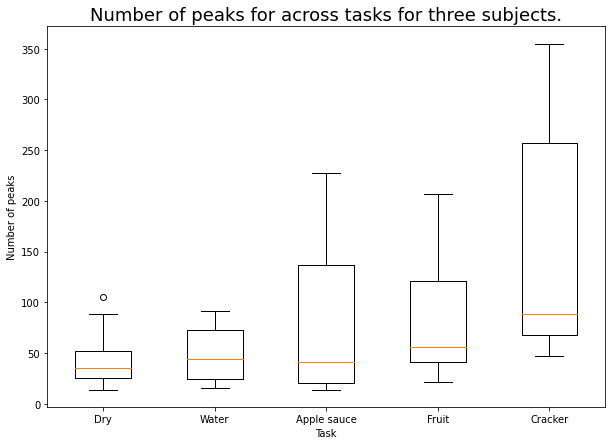

7.351208512900291 3.915826954047257e-05


In [18]:
plt.figure(figsize=(10,7))
plt.boxplot(x_features.T)
plt.xlabel('Task')
plt.xticks(range(1,6),['Dry', 'Water', 'Apple sauce', 'Fruit', 'Cracker'])
plt.ylabel('Number of peaks')
plt.title('Number of peaks for across tasks for three subjects.', fontsize=18)

plt.rc('axes', titlesize=14)
plt.show()

fvalue, pvalue = stats.f_oneway(*x_features)
print(fvalue, pvalue)



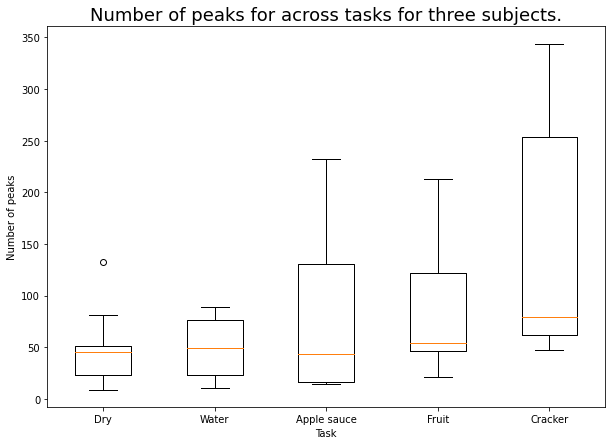

6.675519198219694 0.00010123866403913564


In [16]:
plt.figure(figsize=(10,7))
plt.boxplot(x_features.T)
plt.xlabel('Task')
plt.xticks(range(1,6),['Dry', 'Water', 'Apple sauce', 'Fruit', 'Cracker'])
plt.ylabel('Number of peaks')
plt.title('Number of peaks for across tasks for three subjects.', fontsize=18)

plt.rc('axes', titlesize=14)


plt.show()

fvalue, pvalue = stats.f_oneway(*x_features)
print(fvalue, pvalue)

In [43]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(x_features.T)

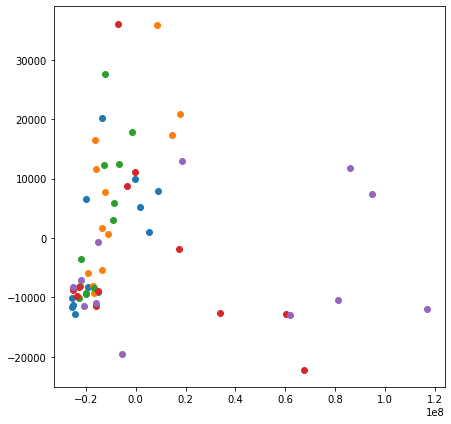

In [44]:
cmap = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(7,7))
for i in range(1,6):
    mask = y_tasks == i 
    plt.scatter(PCs[mask,0],PCs[mask,1])
    # plt.scatter(PCs[mask][:3,0],PCs[mask][:3,1],c='C%s'%i)#,marker='.')
    # plt.scatter(PCs[mask][3:,0],PCs[mask][3:,1],c='C%s'%i)


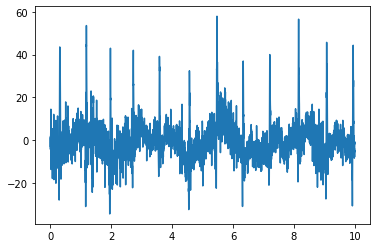

In [49]:
a,b = 0,10
a,b = [int(x*fs) for x in [a,b]]

plt.plot(time[a:b],data_filt[1,a:b])

In [4]:
import os 
import scipy.io as sio
import matplotlib.pyplot as plt

dir = '../Throat Electrophysiology/Subject Data/'
files = os.listdir(dir)
mat_files = [file for file in files if file[:3]=='S16' and file[-4:]=='.mat']
subject_real = {'newdata': np.hstack((np.array(sio.loadmat(dir+mat_file)['newdata']) for mat_file in mat_files))}

dir_new = 'data/raw/'
filename_new = 'S5E0716_Sw.mat'
sio.savemat(dir_new+filename_new, subject_real)


C:\Users\HASSLE~1\AppData\Local\Temp/ipykernel_44768/807480084.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  subject_real = {'newdata': np.hstack((np.array(sio.loadmat(dir+mat_file)['newdata']) for mat_file in mat_files))}


# Statistics across one subject

In [10]:
subject = mats2dict(sub_load=[1])
y_tasks, x_features = return_features(subject, sigma=25)

Subjects imported:  1
Subject information: 	Information	Recording	Sampling Frequency	Timestamps


In [88]:
class

array([[132.,  49.,  77.,  81.,  71.,  51.,  22.,  16.,  16.,  24.,   9.,
         23.,  38.,  47.,  44.,  51.,  44.,  47.],
       [ 77.,  85.,  86.,  82.,  89.,  75.,  11.,  10.,  14.,  29.,  21.,
         16.,  49.,  46.,  57.,  49.,  42.,  52.],
       [ 91., 144., 174., 159., 232., 201.,  15.,  16.,  16.,  14.,  16.,
         19.,  43.,  77.,  45.,  43.,  38.,  43.],
       [135., 142.,  36., 190., 194., 213.,  21.,  59.,  47.,  22.,  83.,
         57.,  51.,  46.,  50.,  71.,  48.,  45.],
       [239., 303., 287., 258., 323., 344.,  79.,  47.,  80.,  55.,  72.,
         69., 107.,  58., 162.,  56.,  60.,  75.]])

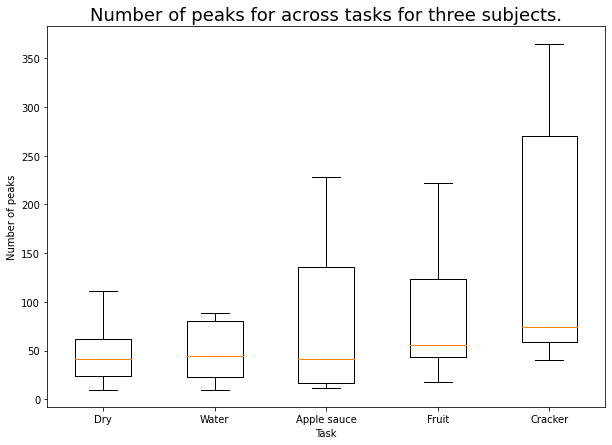

In [7]:
plt.figure(figsize=(10,7))
plt.boxplot(x_features.T)
plt.xlabel('Task')
plt.xticks(range(1,6),['Dry', 'Water', 'Apple sauce', 'Fruit', 'Cracker'])
plt.ylabel('Number of peaks')
plt.title('Number of peaks for across tasks for three subjects.', fontsize=18)

plt.rc('axes', titlesize=14)


plt.show()

#14 labels, 18 title

In [ ]:
plt.f

In [8]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(*x_features)
print(fvalue, pvalue)

6.293814993427549 0.00017441115690043218


In [73]:
x_features[0].reshape(5,6).T

array([[ 38.,  49.,  43.,  51., 107.],
       [ 47.,  46.,  77.,  46.,  58.],
       [ 44.,  57.,  45.,  50., 162.],
       [ 51.,  49.,  43.,  71.,  56.],
       [ 44.,  42.,  38.,  48.,  60.],
       [ 47.,  52.,  43.,  45.,  75.]])